# **Análisis de precios de casas en venta en las principales ciudades de Paraguay**

---


Datos: Los datos son obtenidos mediante web scraping a las dos paginas más importantes de venta de inmuebles.



Este mini proyecto nace cuando empecé a buscar viviendas con el objetivo de comprar una. Viendo los precios tan altos en Asunción, me propuse investigar en qué ciudad estarían las viviendas mas accecibles, y también los precios de las viviendas en la ciudad donde me gustaría vivir.

Se me ocurrió realizar un sencillo scraping utilizando BeautifulSoup en Python, de forma a obtener los datos necesarios para el análisis.

In [1]:
#primeramente utilizo un fake-useragent para realizar los scrapeos.
#!pip install fake-useragent

In [ ]:
#!pip install ydata-profiling


In [1]:
#importar las librerias a utilizar
import warnings
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from fake_useragent import UserAgent
import time
from ydata_profiling import ProfileReport

# Se desactivan los warnings para evitar mensajes innecesarios durante la ejecución
warnings.filterwarnings("ignore")

# Configuración de pandas para mostrar números con formato personalizado
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Desactivar la notación científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
#Creo listas donde se almacenara la informacion
house=[] #lista para guardar el nombre de la casa
prices=[] #lista para guardar el precio de la casa
location = [] #lista para guardar la ciudad donde se ubica la casa

df=pd.DataFrame()

In [3]:
# Función para obtener la página HTML de forma robusta con reintentos y backoff
# Esta función realiza varios intentos en caso de fallo y aplica un tiempo de espera exponencial

def obtener_pagina(url, user_agent, retries=3, backoff_factor=0.3):
    for intento in range(retries):
        try:
            # Realiza la solicitud HTTP con el user agent especificado
            response = requests.get(url, headers={"user-agent": user_agent.chrome})
            response.raise_for_status()  # Genera una excepción si el estado no es 200
            return BeautifulSoup(response.content, "html.parser")  # Devuelve el contenido parseado
        except requests.RequestException as e:
            if intento < retries - 1:  # Solo reintenta si no es el último intento
                sleep_time = backoff_factor * (2 ** intento)  # Calcula el tiempo de espera
                print(f"Error al obtener la URL {url}, reintentando en {sleep_time:.2f} segundos... (Intento {intento + 1})")
                time.sleep(sleep_time)  # Espera antes de reintentar
            else:
                print(f"Error al obtener la URL {url}: {e}")
                return None  # Devuelve None si falla definitivamente

In [4]:
# Función para extraer los datos de múltiples páginas del sitio Clasipar
# Itera sobre un rango de páginas y almacena los datos relevantes en listas

def extraer_datos_clasipar(num_paginas=10):
    base_url = "https://clasipar.paraguay.com/inmuebles/casas/intencion:vendo-t_s/page-{}"
    user_agent = UserAgent()

    for i in range(1, num_paginas + 1):  # Itera sobre un número configurable de páginas
        print(f"Extrayendo datos de la página {i}...")
        page_soup = obtener_pagina(base_url.format(i), user_agent)
        if not page_soup:  # Si no se puede obtener la página, pasa a la siguiente
            continue

        # Busca contenedores que tienen los datos de las casas
        for contenedor in page_soup.findAll('div', {'class': 'box-anuncio__descripcion'}):
            nombre = contenedor.find('a', {'class': 'titAnuncio'})
            precio = contenedor.find('p', {'class': 'price'})
            direccion = contenedor.select_one("h6 a")

            # Verifica que todos los datos estén presentes antes de agregarlos a las listas
            if nombre and precio and direccion:
                house.append(nombre.text.strip())  # Limpia el texto del nombre
                prices.append(precio.text.strip())  # Limpia el texto del precio
                location.append(direccion.text.strip())  # Limpia el texto de la ubicación

    # Crea un DataFrame con los datos recopilados
    return pd.DataFrame({'Nombre': house, 'Precio': prices, 'Ubicación': location})


In [25]:
# Función para procesar y limpiar los datos extraídos del scraping
# Incluye manejo de precios, monedas, y normalización de nombres de ciudades


def procesar_datos(df):
    # Asegurarse de que el DataFrame no esté vacío
    if df.empty:
        print("El DataFrame está vacío después del scraping. Verifique la fuente de datos.")
        return df
    #Agrego la columna de precio del dolar en gs
    df['cot_dolar'] = 7000

    # Asegurar que la columna 'Precio' sea string
    df['Precio'] = df['Precio'].astype(str).str.strip()

    # Filtrar solo los precios que empiezan con "Gs." o "US$."
    df = df[df['Precio'].str.startswith(('Gs.', 'US$'))]

    # Extraer el tipo de moneda
    df['Moneda'] = df['Precio'].str[:3]  # Extrae "Gs." o "US$"

    # Extrae los valores numéricos de los precios y maneja datos faltantes o malformados
    #Creo otra columna solo con el precio, sin la moneda
    df['Precio_Num'] = df['Precio'].str.slice(4, 100)

    #extraigo la parte decimal de los precios en dolares.
    df['Precio_Num'] = df['Precio_Num'].str.split(',').str[0]

    #cambio el tipo de datos a int
    df['Precio_Num']=df['Precio_Num'].replace('\.','',regex=True).astype(int)

    # Convierte los valores a float y maneja errores asignando NaN
    df['Precio_Num'] = pd.to_numeric(df['Precio_Num'], errors='coerce')

    # Elimina filas con precios no numéricos
    df = df.dropna(subset=['Precio_Num'])

    # Calcula el precio en guaraníes basado en la moneda
    df['Precio_Gs'] = np.where(df['Moneda'] == 'US', df['Precio_Num'] * 7000, df['Precio_Num'])

    #obtengo el precio en U$D
    df['Precio_usd'] = np.round(np.where(df.Moneda =='Gs', df.Precio_Num/df.cot_dolar, df.Precio_Num),0)


    # Normaliza los nombres de las ciudades desde la columna 'Ubicación'
    df['Ciudad'] = df['Ubicación'].str.split(',').str[-1].str.strip()
    correcciones = {
        'ambaré': 'Lambaré', 'uque': 'Luque', 'an Antonio': 'San Antonio',
        'an Lorenzo': 'San Lorenzo', 'apiatá': 'Capiatá',
        'ernando de la Mora': 'Fernando de la Mora', 'illa Elisa': 'Villa Elisa'
    }
    df['Ciudad'] = df['Ciudad'].replace(correcciones)
    df['Ciudad'] = df['Ciudad'].str.replace("Casas en ", "", regex=False).str.strip()

    # Identifica y muestra los outliers
    outliers = df[(df['Precio_Gs'] <= 100000000) | (df['Precio_Gs'] >= 1000000000)]
    #if not outliers.empty:
    #    print(f"Se encontraron {len(outliers)} outliers. Estos son:")
    #    print(outliers)

    # Filtra los datos válidos eliminando los outliers
    df = df[(df['Precio_Gs'] > 100000000) & (df['Precio_Gs'] < 1000000000)]

    # Mensaje si el DataFrame procesado queda vacío
    if df.empty:
        print("No hay datos válidos después del procesamiento. Revise las condiciones de filtrado.")
    return df[['Nombre','Ciudad', 'Precio_Gs', 'Precio_usd']]  # Seleccionar solo las columnas requeridas


In [6]:
# Función para guardar los datos procesados en un archivo CSV

def guardar_datos(df, filename):
    df.to_csv(filename, index=False)  # Guarda el DataFrame en formato CSV
    print(f"Datos guardados en {filename}")


In [26]:
# Punto de entrada principal del script
if __name__ == "__main__":
    print("Iniciando scraping de Clasipar...")
    datos = extraer_datos_clasipar()  # Realiza el scraping de los datos
    print("Procesando datos...")
    datos_procesados = procesar_datos(datos)  # Limpia y procesa los datos
    guardar_datos(datos_procesados, "clasipar_procesados.csv")  # Guarda los datos procesados


Iniciando scraping de Clasipar...
Extrayendo datos de la página 1...
Procesando datos...
Datos guardados en clasipar_procesados.csv


# **Exploratory Data Analysis**

In [27]:
datos_procesados.head()

,Nombre,Ciudad,Precio_Gs,Precio_usd
0,VENDO AMPLIA Y HERMOSA CASA ZONA SALENMA SAN L...,San Lorenzo,600000000,600000000.000
1,VENDO CASA CON PISCINA EN YPANE,Ypané,550000000,550000000.000
3,VENDO CASA A ESTRENAR CON PISCINA DE 3 DORMITO...,Luque,350000000,350000000.000
4,TU CASA DE UNA PLANTA EN ASUNCIÓN POR MENOS DE...,Asunción,930000000,930000000.000
8,"Casa de 100 metros cuadrados, cerca del centro...",Areguá,227000000,227000000.000


In [28]:
# Función para generar análisis exploratorio con Pandas Profiling
def generar_perfil(df):
    print("Generando reporte de análisis exploratorio...")
    perfil = ProfileReport(df, explorative=True)
    return perfil


In [29]:
def analizar_datos(df):
    if df.empty:
        print("El DataFrame está vacío. No se puede realizar el análisis.")
        return

    print("Estadísticas descriptivas de los precios en guaraníes:")
    print(df['Precio_Gs'].describe())

    print("Distribución de precios por ciudad:")
    precios_por_ciudad = df.groupby('Ciudad')['Precio_Gs'].mean().sort_values()
    print(precios_por_ciudad)

    # Visualización de precios promedio por ciudad
    if not precios_por_ciudad.empty:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        precios_por_ciudad.plot(kind='barh', color='skyblue')
        plt.xlabel('Precio Promedio (Gs)')
        plt.ylabel('Ciudad')
        plt.title('Precio promedio de casas por ciudad')
        plt.show()
    else:
        print("No hay suficientes datos para generar el gráfico.")


Iniciando scraping de Clasipar...
Extrayendo datos de la página 1...
Procesando datos...
Iniciando análisis de datos...
Estadísticas descriptivas de los precios en guaraníes:
count          94.000
mean    518497718.085
std     230098015.605
min     120000000.000
25%     337750000.000
50%     495000000.000
75%     678750000.000
max     980000000.000
Name: Precio_Gs, dtype: float64
Distribución de precios por ciudad:
Ciudad
Ciudad del Este           145000000.000
Areguá                    247595166.667
Limpio                    275000000.000
Ñemby                     280000000.000
Julián Augusto Saldívar   300000000.000
Emboscada                 300000000.000
Hohenau                   310000000.000
Capiatá                   333333333.333
Coronel Oviedo            420000000.000
Itauguá                   442500000.000
Encarnación               450000000.000
San Lorenzo               473818181.818
Mariano Roque Alonso      480000000.000
Escobar                   490000000.000
Ypané         

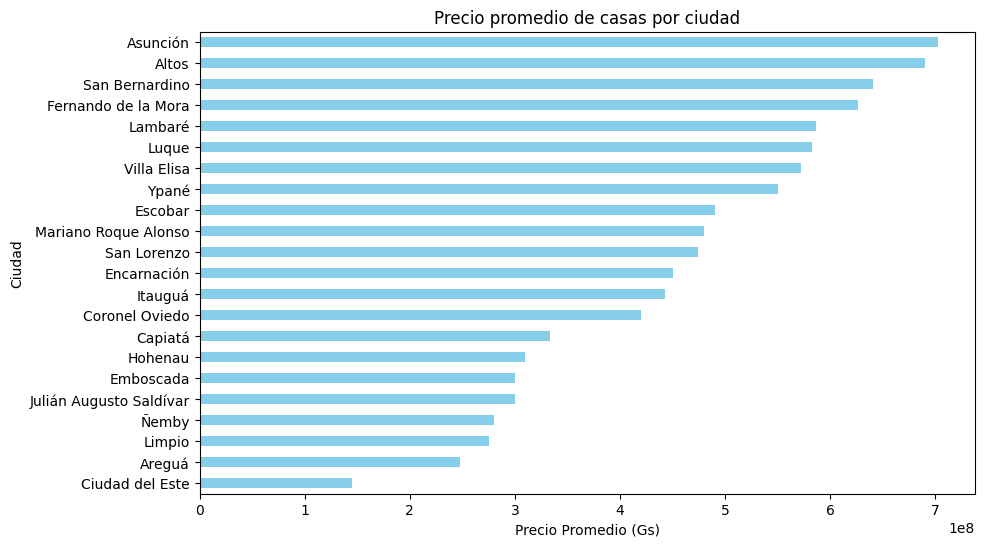

Generando reporte de análisis exploratorio...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
# Punto de entrada principal del script
if __name__ == "__main__":
    print("Iniciando scraping de Clasipar...")
    datos = extraer_datos_clasipar()  # Realiza el scraping de los datos
    print("Procesando datos...")
    datos_procesados = procesar_datos(datos)  # Limpia y procesa los datos

    print("Iniciando análisis de datos...")
    analizar_datos(datos_procesados)  # Realiza el análisis de los datos

    # Generar reporte de Pandas Profiling
    perfil = generar_perfil(datos_procesados)
    perfil.to_notebook_iframe()  # Muestra el perfil en la notebook